# **Deep Learning Lab: Transfer Learning**

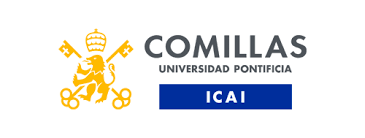

***

## Import packages

In [ ]:
#from cnn_model import CNN, load_data, load_model_weights
from cnn_model_efficientnet import CNN, load_data, load_model_weights
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import wandb
import torch.optim as optim

## Inicializar W&B

In [ ]:
wandb.init(
    project="MLII-Grupo6-2025",
    name="convnext_base_unfreezed5_epochs10",
    config={
        "batch_size": 32,
        "img_size": 224,
        "optimizer": "Adam",
        "learning_rate": 0.0001,
        "epochs": 10,
        "unfreezed_layers": 5,
        "model": "convnext_base"
    }
)

## Model and data loading


In [ ]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

In [ ]:
# Load data and model 
train_dir = '/Users/martaalvarez/MLII-Grupo6/Project_Grupo6_MLII/dataset/training'
valid_dir = '/Users/martaalvarez/MLII-Grupo6/Project_Grupo6_MLII/dataset/validation'

train_loader, valid_loader, num_classes = load_data(train_dir, 
                                                    valid_dir, 
                                                    batch_size=32, #
                                                    img_size=224) 
model = CNN(
    torchvision.models.vit_b_16(weights='IMAGENET1K_V1'),
    num_classes,
    unfreezed_layers=5
)

In [ ]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])

## Train

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()
history = model.train_model(
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=7,
)

In [ ]:
torch.save(model.state_dict(), "vit_b_16_unfreezed_layers_5_epochs_7.pt")

In [ ]:
model.save_model('resnext101_64x4d_2epoch_1descongelado')

## Predict

#### Load model

In [ ]:
# Load model
model_weights = load_model_weights('resnext101_64x4d-10epoch')
my_trained_model = CNN(torchvision.models.resnext101_64x4d(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

## Results

In [ ]:
predicted_labels = my_trained_model.predict(valid_loader)

In [ ]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])
